In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

In [11]:
def read_minibatch_trainhistory(file_names, nbatches_artifical=1, start_words='Epoch'):
    train_loss = []
    train_epoch = []
    for file_name in file_names:
        with open(file_name, 'r') as f:
            for row in f:
                if row.startswith(start_words):
                    epoch = int(row.split()[1])-1
                    batch = int(row.split()[3])
                    loss = float(row.split()[-1])
                    train_epoch.append(epoch+batch/float(nbatches_artifical))
                    train_loss.append(loss)

    return train_epoch, train_loss

In [12]:
def read_epoch_log(file_names, start_words='DONE SYNCING - NOW LOGGING'):
    train_time = []
    valid_time = []
    postproces_time = []
    train_loss = []
    valid_loss = []
    epochs = []
    for file_name in file_names:
        with open(file_name, 'r') as f:
            for row in f:
                if row.startswith(start_words):
                    line = next(f)

                    try:
                        assert line.startswith("Time for train")
                    except:
                        try:
                            assert line.startswith("{'train_rmse':")
                            line = next(f)
                            assert line.startswith("Time for train")
                        except:
                            print("Unexpected line: ", line)
                            
                    train_time.append(float(line.split()[3][:-1]))
                    valid_time.append(float(line.split()[6][:-1]))
                    print(line.split()[-1][:])
                    print(line.split()[-1][len("postprocessing:"):])
                    postproces_time.append(float(line.split()[-1][len("postprocessing:"):]))

                    line = next(f)
                    assert line.startswith("Time taken for epoch")
                    epochs.append(int(line.split()[4]))

                    line = next(f)
                    assert line.startswith("Train loss:")
                    try:
                        train_loss.append(float(line.split()[2][:-1]))
                    except: #Train loss: tensor([0.5132], device='cuda:0'). Valid loss: 0.33667054772377014
                        train_loss.append(float(line.split()[2][8:14]))
                    valid_loss.append(float(line.split()[-1][:-1]))

    return epochs, train_time, valid_time, postproces_time, train_loss, valid_loss

In [13]:
def get_logfiles(dir, end_words='.out'):
    files=[]
    for file in os.listdir(dir):
        if file.endswith(end_words):
            files.append(os.path.join(dir, file))
    return sorted(files)

In [14]:
#log_dirs = ["../test-1608255.out", "../test-1610769.out"]
#nbatches_artifical=2000
cases = ["tiny", "big"]
output_dir = "../outputs"
output_log={}
for case in cases: 
    output_log[case]={}
    log_dirs = get_logfiles(os.path.join(output_dir, case))
    print(len(log_dirs),log_dirs)
    output_log[case]["logfiles"]=log_dirs
    nbatches_artifical=200
    epochs_minibatch, train_minibatch_loss = read_minibatch_trainhistory(log_dirs, nbatches_artifical=nbatches_artifical) 
    epochs, train_time, valid_time, postproces_time, train_loss, valid_loss = read_epoch_log(log_dirs)
    output_log[case]["epochs_minibatch"] = epochs_minibatch
    output_log[case]["train_minibatch_loss"] = train_minibatch_loss
    output_log[case]["epochs"] = epochs
    output_log[case]["train_time"] = train_time
    output_log[case]["valid_time"] = valid_time
    output_log[case]["postproces_time"] = postproces_time
    output_log[case]["train_loss"] = train_loss
    output_log[case]["valid_loss"] = valid_loss


19 ['../outputs/tiny/test-1615151.out', '../outputs/tiny/test-1617531.out', '../outputs/tiny/test-1617534.out', '../outputs/tiny/test-1617535.out', '../outputs/tiny/test-1617542.out', '../outputs/tiny/test-1619013.out', '../outputs/tiny/test-1619014.out', '../outputs/tiny/test-1619015.out', '../outputs/tiny/test-1619016.out', '../outputs/tiny/test-1620623.out', '../outputs/tiny/test-1620624.out', '../outputs/tiny/test-1628318.out', '../outputs/tiny/test-1628319.out', '../outputs/tiny/test-1628320.out', '../outputs/tiny/test-1628321.out', '../outputs/tiny/test-1628322.out', '../outputs/tiny/test-noaccugrad-1628374.out', '../outputs/tiny/test-noaccugrad-1628907.out', '../outputs/tiny/test-noaccugrad-1628916.out']
postprocessing:11.776649475097656
11.776649475097656
postprocessing:7.888282060623169
7.888282060623169
postprocessing:8.176280975341797
8.176280975341797
postprocessing:8.89450192451477
8.89450192451477
postprocessing:8.33822751045227
8.33822751045227
postprocessing:8.535438776

In [15]:
def get_record(output_log, case):
    epochs_minibatch = output_log[case]["epochs_minibatch"]
    train_minibatch_loss = output_log[case]["train_minibatch_loss"]
    epochs = output_log[case]["epochs"]  
    train_time = output_log[case]["train_time"] 
    valid_time=output_log[case]["valid_time"] 
    postproces_time=output_log[case]["postproces_time"]
    train_loss = output_log[case]["train_loss"] 
    valid_loss = output_log[case]["valid_loss"]
    return epochs, train_time, valid_time,postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss

In [16]:
def plot_loss(ax, epochs, train_loss, valid_loss, epochs_minibatch=None, train_minibatch_loss=None, case=""):
    if epochs_minibatch is not None:
        ax.plot(epochs_minibatch, train_minibatch_loss, alpha=0.2)
    ax.plot(epochs, train_loss, label=case+'-Train')
    ax.plot(epochs, valid_loss, label=case+'-valid')
    return ax

In [17]:
def plot_time(ax, epochs, train_time, valid_time, postproces_time, case=""):
    ax.plot(epochs, train_time, label=case+'-Train')
    ax.plot(epochs, valid_time, label=case+'-valid')
    ax.plot(epochs, postproces_time, label=case+'-postp')
    return ax

tiny 0.06161327287554741 0.0694113224744796
big 0.030049849301576614 0.0353169105947017


Text(0, 0.5, 'Time')

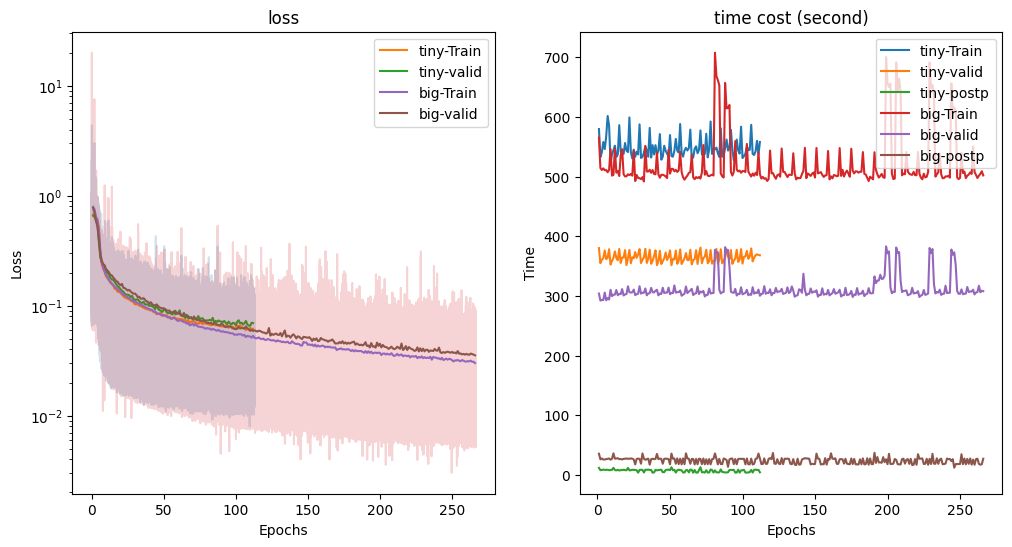

In [18]:
fig = plt.figure(figsize=(12, 6))

ax=fig.add_subplot(1,2,1) 
for case in cases:
    epochs, train_time, valid_time,postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
    print(case, train_loss[-1], valid_loss[-1])
    ax=plot_loss(ax, epochs, train_loss, valid_loss, epochs_minibatch=epochs_minibatch, train_minibatch_loss=train_minibatch_loss, case=case)
ax.legend()
ax.set_title("loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale('log')

ax=fig.add_subplot(1,2,2) 
for case in cases:
    epochs, train_time, valid_time, postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
    ax=plot_time(ax, epochs, train_time, valid_time, postproces_time, case=case)
ax.legend()
ax.set_title("time cost (second)")
ax.set_xlabel("Epochs")
ax.set_ylabel("Time")



tiny 0.06161327287554741 0.0694113224744796
big 0.030049849301576614 0.0353169105947017


Text(0, 0.5, 'Time')

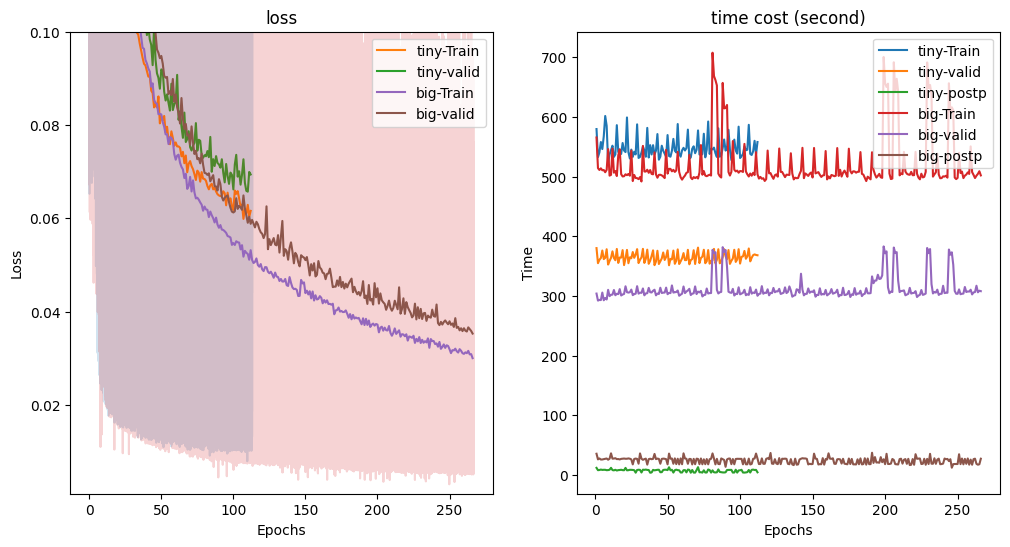

In [19]:
fig = plt.figure(figsize=(12, 6))

ax=fig.add_subplot(1,2,1) 
for case in cases:
    epochs, train_time, valid_time,postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
    print(case, train_loss[-1], valid_loss[-1])
    ax=plot_loss(ax, epochs, train_loss, valid_loss, epochs_minibatch=epochs_minibatch, train_minibatch_loss=train_minibatch_loss, case=case)
ax.legend()
ax.set_title("loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
#ax.set_yscale('log')
ax.set_ylim(1e-3, 1e-1)

ax=fig.add_subplot(1,2,2) 
for case in cases:
    epochs, train_time, valid_time, postproces_time, train_loss, valid_loss, epochs_minibatch, train_minibatch_loss = get_record(output_log, case)
    ax=plot_time(ax, epochs, train_time, valid_time, postproces_time, case=case)
ax.legend()
ax.set_title("time cost (second)")
ax.set_xlabel("Epochs")
ax.set_ylabel("Time")

